# Reproducibility analysis

Here we are going to analize the exported data of the skiboot testing machine (force, angular displacement) in terms of reproducibility. The machine data export in .tdms format is converted by "tdms file importer" created by Raph to .csv files which contain for every experiment the data of all below listed sessions.   

Experiments at Montebelluna 08.01.2021: Cyclic loading of TLT Speedfit DX and SX with maximal angular displacement as input, starting at an absolut neutral angle of 15°
Frequency: f=0.7 Hz
ambient = 20°C
cold = -20°C
Session 1: max. 20,5°
Session 2: max. 22,5°
Session 3: max. 25,5°
Session 4: max. 30,5°

For each boot (DX and SX) two experiments (ambient and cold) were done containing 4 sessions a 10 cycles each. For each experiment a time series file in .csv is loaded.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
#path_file = "C:\Users\kurmaril\Desktop\Sharepoint_Data\CSVexports_timeseries"
#path_file = sys.path.insert(0, '/path/to/application/app/Sharepoint_Data/CSVexports_timeseries')
    
mtb_filename = 'Montebelluna_8Jan21_time_series.csv'

df_mtb = pd.read_csv(mtb_filename, index_col = 0)

# converting time column into correct time format
df_mtb["time"] = pd.to_datetime(df_mtb["time"])
df_mtb.sort_values("time", inplace = True)
df_mtb.reset_index(drop = True, inplace = True)

print("Start time: " + str(df_mtb["time"].min()))
print(df_mtb.info())

Start time: 2021-01-08 10:10:55.052250
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400070 entries, 0 to 400069
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        400070 non-null  datetime64[ns]
 1   experiment  400070 non-null  object        
 2   session #   400070 non-null  int64         
 3   cycle #     400070 non-null  int64         
 4   position    400070 non-null  float64       
 5   force       400070 non-null  float64       
 6   temp        400070 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 21.4+ MB
None


# Standard deviation analysis
For each experiment the standard deviation of the ratio "force/position" is calculated for every single session 1-4. The result is shown in the plot below. Attention: For "DXAmbient" only cycle 1 and 10 have been registred, for the other 3 experiments 10 cycles each. 

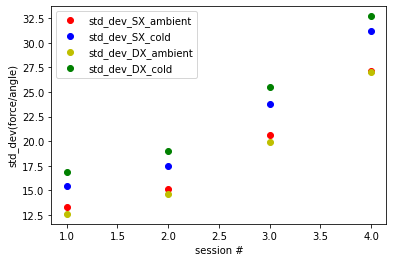

In [4]:
# Calculating standard deviation from (force/position) for every single experiment

# DXambient
df_DXambient = df_mtb[df_mtb["experiment"] == "DxAmbient"]
df_DX_ambient_s = {}
std_dev_DX_ambient_s = {}
# DX cold
df_DXcold = df_mtb[df_mtb["experiment"] == "DxCold"]
df_DX_cold_s = {}
std_dev_DX_cold_s = {}

# SX ambient
df_SXambient = df_mtb[df_mtb["experiment"] == "SxAmbient"]
df_SX_ambient_s = {}
std_dev_SX_ambient_s = {}
# SX cold
df_SXcold = df_mtb[df_mtb["experiment"] == "SxCold"]
df_SX_cold_s = {}
std_dev_SX_cold_s = {}

for i in range(1,5):
    df_SX_ambient_s[i] = df_SXambient[df_SXambient["session #"] == i]
    std_dev_SX_ambient_s[i] = np.std(df_SX_ambient_s[i]['force']/df_SX_ambient_s[i]['position'])
    df_SX_cold_s[i] = df_SXcold[df_SXcold["session #"] == i]
    std_dev_SX_cold_s[i] = np.std(df_SX_cold_s[i]['force']/df_SX_cold_s[i]['position'])
    df_DX_ambient_s[i] = df_DXambient[df_DXambient["session #"] == i]
    std_dev_DX_ambient_s[i] = np.std(df_DX_ambient_s[i]['force']/df_DX_ambient_s[i]['position'])
    df_DX_cold_s[i] = df_DXcold[df_DXcold["session #"] == i]
    std_dev_DX_cold_s[i] = np.std(df_DX_cold_s[i]['force']/df_DX_cold_s[i]['position'])

std_dev_SX_ambient = pd.DataFrame(std_dev_SX_ambient_s,index=[1]).transpose()
std_dev_SX_cold = pd.DataFrame(std_dev_SX_cold_s,index=[1]).transpose()
std_dev_DX_ambient = pd.DataFrame(std_dev_DX_ambient_s,index=[1]).transpose()
std_dev_DX_cold = pd.DataFrame(std_dev_DX_cold_s,index=[1]).transpose()

plt.plot(std_dev_SX_ambient,'ro',std_dev_SX_cold,'bo',std_dev_DX_ambient,'yo',std_dev_DX_cold,'go')
plt.legend(['std_dev_SX_ambient','std_dev_SX_cold','std_dev_DX_ambient','std_dev_DX_cold'])
plt.xlabel('session #')
plt.ylabel('std_dev(force/angle)')
plt.show()

The trend between the experiments is similar, the standard deviation of the force/angle ratio in DXambient and SXambient for each session seems quite similar, where there is a significant offset between the "ambient" and "cold" experiments.
It has to be mentioned, that every boot seems to deliver different result on the skiboot testing machine, but also at the current project stage we are not sure about the influences on the test method itself, e.g. discrapancy between left and right prothesis or buckle closure.

# MinMax analysis

The protocol for the different experiments is always the same: for each session 1-4 the boot is loaded in forward lean until a maximum angle (called 'position' in the dataframe) for every single cycle 1-10 and the correspondent force is measured. Also in backward an minimum angle is presetted and the corresponding force evaluated. In this section we will take a look at the forces for the maximum and minimum angle for the single cycles within a session of an experiment.
In addition also the difference in amplitude between peaks (max) and valleys (min) for each cycle is calculated.

In [33]:
# SX_AMBIENT, SX_COLD & DX_COLD
df_SX_ambient_s_c = {}
max_force_SX_ambient_s_c = {}
min_force_SX_ambient_s_c = {}
df_SX_cold_s_c = {}
max_force_SX_cold_s_c = {}
min_force_SX_cold_s_c = {}
df_DX_ambient_s_c = {}
max_force_DX_ambient_s_c = {}
min_force_DX_ambient_s_c = {}
df_DX_cold_s_c = {}
max_force_DX_cold_s_c = {}
min_force_DX_cold_s_c = {}

for i in range(1,5):
    for j in range(1,10):
        df_SX_ambient_s_c[i,j] = df_SX_ambient_s[i][df_SX_ambient_s[i]["cycle #"] == j]
        max_force_SX_ambient_s_c[i,j] = max(df_SX_ambient_s_c[i,j]['force'])
        min_force_SX_ambient_s_c[i,j] = min(df_SX_ambient_s_c[i,j]['force'])
        df_SX_cold_s_c[i,j] = df_SX_cold_s[i][df_SX_cold_s[i]["cycle #"] == j]
        max_force_SX_cold_s_c[i,j] = max(df_SX_cold_s_c[i,j]['force'])
        min_force_SX_cold_s_c[i,j] = min(df_SX_cold_s_c[i,j]['force'])
        df_DX_cold_s_c[i,j] = df_DX_cold_s[i][df_DX_cold_s[i]["cycle #"] == j]
        max_force_DX_cold_s_c[i,j] = max(df_DX_cold_s_c[i,j]['force'])
        min_force_DX_cold_s_c[i,j] = min(df_DX_cold_s_c[i,j]['force'])
    df_DX_ambient_s_c[i,1] = df_DX_ambient_s[i][df_DX_ambient_s[i]["cycle #"] == 1]
    max_force_DX_ambient_s_c[i,1] = max(df_DX_ambient_s_c[i,1]['force'])
    min_force_DX_ambient_s_c[i,1] = min(df_DX_ambient_s_c[i,1]['force'])
    df_DX_ambient_s_c[i,2] = df_DX_ambient_s[i][df_DX_ambient_s[i]["cycle #"] == 10]
    max_force_DX_ambient_s_c[i,2] = max(df_DX_ambient_s_c[i,2]['force'])
    min_force_DX_ambient_s_c[i,2] = min(df_DX_ambient_s_c[i,2]['force'])
        
max_force_SX_ambient_s_c = pd.DataFrame(max_force_SX_ambient_s_c,index=[1]).transpose()
min_force_SX_ambient_s_c = pd.DataFrame(min_force_SX_ambient_s_c,index=[1]).transpose()
max_force_SX_cold_s_c = pd.DataFrame(max_force_SX_cold_s_c,index=[1]).transpose()
min_force_SX_cold_s_c = pd.DataFrame(min_force_SX_cold_s_c,index=[1]).transpose()
max_force_DX_cold_s_c = pd.DataFrame(max_force_DX_cold_s_c,index=[1]).transpose()
min_force_DX_cold_s_c = pd.DataFrame(min_force_DX_cold_s_c,index=[1]).transpose()
max_force_DX_ambient_s_c = pd.DataFrame(max_force_DX_ambient_s_c,index=[1]).transpose()
min_force_DX_ambient_s_c = pd.DataFrame(min_force_DX_ambient_s_c,index=[1]).transpose()

# Calculating difference between min und max within one cycle
diff_force_SX_ambient = {}
diff_force_SX_cold = {}
std_diff_SX_cold = {}
for i in range(1,5):
    for j in range(1,10):
        diff_force_SX_ambient[i,j] = max_force_SX_ambient_s_c.loc[i,j] - min_force_SX_ambient_s_c.loc[i,j]
        diff_force_SX_cold[i,j] = max_force_SX_cold_s_c.loc[i,j] - min_force_SX_cold_s_c.loc[i,j]

print(std_diff_SX_cold)
        
# Max force plot per session 1-4
fig1, ax1 = plt.subplots(2, 2, figsize=(13, 11))
ax1[0,0].plot(max_force_SX_ambient_s_c.loc[1,:],'ro',max_force_SX_cold_s_c.loc[1,:],'bo',max_force_DX_cold_s_c.loc[1,:],'go',max_force_DX_ambient_s_c.loc[1,1],'yo')
ax1[0,0].set(xlabel= 'cycle #', ylabel='max(F)')
ax1[0,0].set_title('Session 1')
ax1[0,1].plot(max_force_SX_ambient_s_c.loc[2,:],'ro',max_force_SX_cold_s_c.loc[2,:],'bo',max_force_DX_cold_s_c.loc[1,:],'go',max_force_DX_ambient_s_c.loc[2,1],'yo')
ax1[0,1].set(xlabel= 'cycle #',ylabel='max(F)')
ax1[0,1].set_title('Session 2')
ax1[1,0].plot(max_force_SX_ambient_s_c.loc[3,:],'ro',max_force_SX_cold_s_c.loc[3,:],'bo',max_force_DX_cold_s_c.loc[1,:],'go',max_force_DX_ambient_s_c.loc[3,1],'yo')
ax1[1,0].set(xlabel= 'cycle #',ylabel='max(F)')
ax1[1,0].set_title('Session 3')
ax1[1,1].plot(max_force_SX_ambient_s_c.loc[4,:],'ro',max_force_SX_cold_s_c.loc[4,:],'bo',max_force_DX_cold_s_c.loc[1,:],'go',max_force_DX_ambient_s_c.loc[4,1],'yo')
ax1[1,1].set(xlabel= 'cycle #',ylabel='max(F)')
ax1[1,1].set_title('Session 4')
plt.legend(['std_dev_SX_ambient','std_dev_SX_cold','std_dev_DX_cold','std_dev_DX_ambient'])
fig1.suptitle('Maxium force per cycle', fontsize=12)

# Min force plot per session 1-4
fig2, ax2 = plt.subplots(2, 2, figsize=(13, 11))
ax2[0,0].plot(min_force_SX_ambient_s_c.loc[1,:],'ro',min_force_SX_cold_s_c.loc[1,:],'bo',min_force_DX_cold_s_c.loc[1,:],'go',min_force_DX_ambient_s_c.loc[1,1],'yo')
ax2[0,0].set(xlabel= 'cycle #', ylabel='min(F)')
ax2[0,0].set_title('Session 1')
ax2[0,1].plot(min_force_SX_ambient_s_c.loc[2,:],'ro',min_force_SX_cold_s_c.loc[2,:],'bo',min_force_DX_cold_s_c.loc[2,:],'go',min_force_DX_ambient_s_c.loc[2,1],'yo')
ax2[0,1].set(xlabel= 'cycle #',ylabel='min(F)')
ax2[0,1].set_title('Session 2')
ax2[1,0].plot(min_force_SX_ambient_s_c.loc[3,:],'ro',min_force_SX_cold_s_c.loc[3,:],'bo',min_force_DX_cold_s_c.loc[3,:],'go',min_force_DX_ambient_s_c.loc[3,1],'yo')
ax2[1,0].set(xlabel= 'cycle #',ylabel='min(F)')
ax2[1,0].set_title('Session 3')
ax2[1,1].plot(min_force_SX_ambient_s_c.loc[4,:],'ro',min_force_SX_cold_s_c.loc[4,:],'bo',min_force_DX_cold_s_c.loc[4,:],'go',min_force_DX_ambient_s_c.loc[4,1],'yo')
ax2[1,1].set(xlabel= 'cycle #',ylabel='min(F)')
ax2[1,1].set_title('Session 4')
plt.legend(['std_dev_SX_ambient','std_dev_SX_cold','std_dev_DX_cold','std_dev_DX_ambient'])
fig2.suptitle('Minimum force per cycle', fontsize=12)

plt.show()

TypeError: unhashable type: 'slice'

# Standard deviation of min & max 

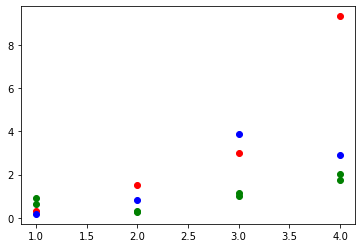

In [20]:
# Per session
std_max_force_DX = pd.DataFrame()
std_min_force_DX = pd.DataFrame()
std_max_force_SX = pd.DataFrame()
std_min_force_SX = pd.DataFrame()

for i in range(1,5):
    std_max_force_SX[i] = [np.std(max_force_SX_ambient_s_c.loc[i,:]), np.std(max_force_SX_cold_s_c.loc[i,:])]
    std_min_force_SX[i] = [np.std(min_force_SX_ambient_s_c.loc[i,:]), np.std(min_force_SX_cold_s_c.loc[i,:])]
    std_max_force_DX[i] = [np.std(max_force_DX_cold_s_c.loc[i,:])]
    std_min_force_DX[i] = [np.std(min_force_DX_cold_s_c.loc[i,:])]

plt.plot(std_max_force_SX.loc[0],'ro',std_max_force_SX.loc[1],'bo',std_min_force_SX.loc[0],'go',std_min_force_SX.loc[1],'go')
plt.show()

# MinMax Plot

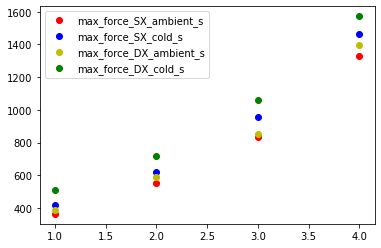

In [11]:
# Min & Max value per experiment and session
df_SX_ambient_max = {}
df_SX_cold_max = {}
df_DX_ambient_max = {}
df_DX_cold_max = {}

for i in range(1,5):
    df_SX_ambient_max[i] = max(df_SXambient[df_SXambient["session #"] == i]['force'])
    df_SX_cold_max[i] = max(df_SXcold[df_SXcold["session #"] == i]['force'])
    df_DX_cold_max[i] = max(df_DXcold[df_DXcold["session #"] == i]['force'])
    df_DX_ambient_max[i] = max(df_DXambient[df_DXambient["session #"] == i]['force'])
    
max_force_SX_ambient_s = pd.DataFrame(df_SX_ambient_max,index=[1]).transpose()
max_force_SX_cold_s = pd.DataFrame(df_SX_cold_max,index=[1]).transpose()
max_force_DX_ambient_s = pd.DataFrame(df_DX_ambient_max,index=[1]).transpose()
max_force_DX_cold_s = pd.DataFrame(df_DX_cold_max,index=[1]).transpose()
df_mtb['position']    
plt.plot(max_force_SX_ambient_s,'ro',max_force_SX_cold_s,'bo',max_force_DX_ambient_s,'yo',max_force_DX_cold_s,'go')
plt.legend(['max_force_SX_ambient_s','max_force_SX_cold_s','max_force_DX_ambient_s','max_force_DX_cold_s'])
plt.show()

In [7]:
min_force_SX_ambient_s

NameError: name 'min_force_SX_ambient_s' is not defined